2024-03-22 01:43:48.050066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 01:43:49.492177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN th

Epoch 1, Train Accuracy: 0.4397, Train Loss: 1.9577


Evaluating: 100%|██████████| 15875/15875 [01:51<00:00, 142.17it/s]


Epoch 1, F1 Score: 0.6182, WER Score: 1.3858


Training: 100%|██████████| 2320/2320 [09:30<00:00,  4.06it/s]


Epoch 2, Train Accuracy: 0.6172, Train Loss: 1.0851


Evaluating: 100%|██████████| 15875/15875 [01:53<00:00, 140.27it/s]


Epoch 2, F1 Score: 0.6368, WER Score: 1.1830


Training: 100%|██████████| 2320/2320 [09:30<00:00,  4.06it/s]


Epoch 3, Train Accuracy: 0.7110, Train Loss: 0.7234


Evaluating: 100%|██████████| 15875/15875 [01:51<00:00, 142.64it/s]


Epoch 3, F1 Score: 0.6482, WER Score: 1.1217


Training: 100%|██████████| 2320/2320 [09:31<00:00,  4.06it/s]


Epoch 4, Train Accuracy: 0.7784, Train Loss: 0.4872


Evaluating: 100%|██████████| 15875/15875 [01:51<00:00, 142.79it/s]


Epoch 4, F1 Score: 0.6426, WER Score: 1.0801


Training: 100%|██████████| 2320/2320 [09:30<00:00,  4.06it/s]


Epoch 5, Train Accuracy: 0.8340, Train Loss: 0.3310


Evaluating: 100%|██████████| 15875/15875 [01:50<00:00, 143.13it/s]


Epoch 5, F1 Score: 0.6327, WER Score: 1.1944


Training: 100%|██████████| 2320/2320 [09:30<00:00,  4.06it/s]


Epoch 6, Train Accuracy: 0.8708, Train Loss: 0.2439


Evaluating: 100%|██████████| 15875/15875 [01:51<00:00, 141.86it/s]


Epoch 6, F1 Score: 0.6370, WER Score: 1.2380
F1 Score List: [0.6181825106571865, 0.6368177246147646, 0.648175541101336, 0.6425898350648814, 0.6327288794899458, 0.6370497734403124]
Word Error Rate List: [1.3857951907900845, 1.1829727973261535, 1.121678581375917, 1.0801411196731965, 1.1943552130721382, 1.2379723331167023]


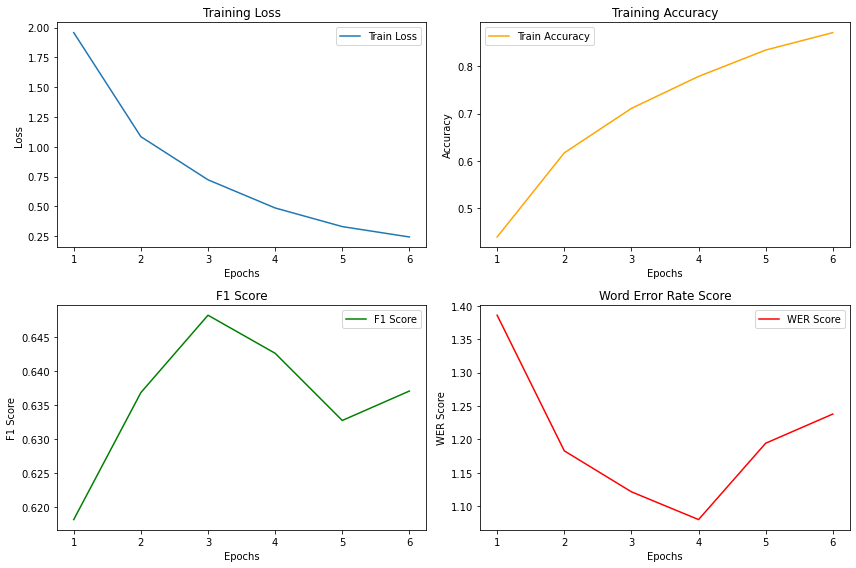

In [1]:
import json
import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from evaluate import load
from collections import Counter
import string
import re
import matplotlib.pyplot as plt
import os


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_data_path = 'spoken_train-v1.1.json'
test_data_path = 'spoken_test-v1.1.json'
MAX_LENGTH = 512
MODEL_PATH = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
epochs = 6 
doc_stride = 128


def load_and_preprocess_data(path):
    with open(path, 'rb') as f:
        raw_data = json.load(f)
    contexts, questions, answers = [], [], []
    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context'].lower()
            for qa in paragraph['qas']:
                question = qa['question'].lower()
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append({'text': answer['text'].lower(), 'answer_start': answer['answer_start'], 'answer_end': answer['answer_start'] + len(answer['text'])})
    return contexts, questions, answers

train_contexts, train_questions, train_answers = load_and_preprocess_data(train_data_path)
valid_contexts, valid_questions, valid_answers = load_and_preprocess_data(test_data_path)

def tokenize_and_align_answers(questions, contexts, answers):
    tokenized_inputs = tokenizer(questions, contexts, max_length=MAX_LENGTH, truncation=True, padding=True, return_offsets_mapping=False, stride = doc_stride)
    start_positions = []
    end_positions = []

    for idx, answer in enumerate(answers):
        answer_encoding = tokenizer(answer['text'], max_length=MAX_LENGTH, truncation=True, padding=True)
        start_position = 0
        end_position = 0
        for pos in range(len(tokenized_inputs['input_ids'][idx]) - len(answer_encoding['input_ids']) + 1):
            match = True
            for i in range(1, len(answer_encoding['input_ids']) - 1):
                if answer_encoding['input_ids'][i] != tokenized_inputs['input_ids'][idx][pos + i]:
                    match = False
                    break
            if match:
                start_position = pos + 1
                end_position = pos + i + 1
                break
        start_positions.append(start_position)
        end_positions.append(end_position)

    tokenized_inputs.update({'start_positions': start_positions, 'end_positions': end_positions})
    return tokenized_inputs

train_encodings = tokenize_and_align_answers(train_questions, train_contexts, train_answers)
valid_encodings = tokenize_and_align_answers(valid_questions, valid_contexts, valid_answers)

class QuestionAnswerDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = QuestionAnswerDataset(train_encodings)
valid_dataset = QuestionAnswerDataset(valid_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1)

model = DistilBertForQuestionAnswering.from_pretrained(MODEL_PATH)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)

def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):
    
    softmax = nn.Softmax(dim=1)
    start_probabilities = softmax(start_logits)
    inv_start_probabilities = 1 - start_probabilities
    end_probabilities = softmax(end_logits)
    inv_end_probabilities = 1 - end_probabilities
    
    log_softmax = nn.LogSoftmax(dim=1)
    log_start_probabilities = log_softmax(start_logits)
    log_end_probabilities = log_softmax(end_logits)
    
    negative_log_likelihood_loss = nn.NLLLoss()
    
    focal_loss_start = negative_log_likelihood_loss(torch.pow(inv_start_probabilities, gamma) * log_start_probabilities, start_positions)
    focal_loss_end = negative_log_likelihood_loss(torch.pow(inv_end_probabilities, gamma) * log_end_probabilities, end_positions)
    
    return (focal_loss_start + focal_loss_end) / 2

def train(model, dataloader, optimizer):
    model.train()
    losses = []
    accuracies = []
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        start_logits, end_logits = outputs.start_logits, outputs.end_logits
        
        loss = focal_loss_fn(start_logits, end_logits, start_positions, end_positions, 1)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        start_pred = torch.argmax(start_logits, dim=1)
        end_pred = torch.argmax(end_logits, dim=1)
        start_accuracy = (start_pred == start_positions).sum() / len(start_pred)
        end_accuracy = (end_pred == end_positions).sum() / len(end_pred)
        accuracies.append(start_accuracy.item())
        accuracies.append(end_accuracy.item())

    avg_loss = sum(losses) / len(losses)
    avg_accuracy = sum(accuracies) / len(accuracies)
    return avg_loss, avg_accuracy

def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score_calc(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def evaluate(model, dataloader):
    model.eval()
    predictions = []
    references = []
    f1_scores = []
    answer_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            start_pred = torch.argmax(start_logits, dim=1)
            end_pred = torch.argmax(end_logits, dim=1)

            for i in range(input_ids.size(0)):
                pred_answer = tokenizer.decode(input_ids[i][start_pred[i]:end_pred[i]+1])
                true_answer = tokenizer.decode(input_ids[i][start_true[i]:end_true[i]+1])
                answer_list.append([pred_answer, true_answer])
                f1_score_value = f1_score_calc(pred_answer, true_answer)
                f1_scores.append(f1_score_value)

    for ans_pair in answer_list:
        if len(ans_pair[0]) == 0:
            ans_pair[0] = "$"
        if len(ans_pair[1]) == 0:
            ans_pair[1] = "$"
        predictions.append(ans_pair[0])
        references.append(ans_pair[1])

    wer_metric = load("wer")
    wer_score = wer_metric.compute(predictions=predictions, references=references)
    avg_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    return avg_f1_score, wer_score

f1_scores = []
wer_scores = []
train_loss_list = []
train_accuracy_list = []
model_save_path = 'distilbert_qa_medium_model_docstride128'

if os.path.exists(model_save_path):
    model = DistilBertForQuestionAnswering.from_pretrained(model_save_path)
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_save_path)
    print(f'Model and tokenizer loaded from {model_save_path}')
    f1_score, wer_score = evaluate(model, valid_loader)
    print(f'F1 Score: {f1_score:.4f}, WER Score: {wer_score:.4f}')
else:
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")

        f1_score, wer_score = evaluate(model, valid_loader)
        f1_scores.append(f1_score)
        wer_scores.append(wer_score)

        print(f"Epoch {epoch + 1}, F1 Score: {f1_score:.4f}, WER Score: {wer_score:.4f}")

    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

print('F1 Score List:', f1_scores)
print('Word Error Rate List:', wer_scores)

epochs_list = list(range(1, epochs + 1))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs_list, train_loss_list, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_list, train_accuracy_list, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs_list, f1_scores, label='F1 Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs_list, wer_scores, label='WER Score', color='red')
plt.xlabel('Epochs')
plt.ylabel('WER Score')
plt.title('Word Error Rate Score')
plt.legend()

plt.tight_layout()
plt.show()